<a href="https://www.kaggle.com/samarthbatav/ml-model-fish?scriptVersionId=88852778" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import seaborn as sns

In [2]:
path = '../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
folder_list = [x for x in os.listdir(path) if '.' not in x]
ds = []
for n,x in enumerate(folder_list):
    for i in os.listdir(path+'/'+x+'/'+x):
        ds.append([path+'/'+x+'/'+x+'/'+i,n,x])

df = pd.DataFrame(ds,columns=['Path','Label','Name'])
df.head()

,Path,Label,Name
0,../input/a-large-scale-fish-dataset/Fish_Datas...,0,Hourse Mackerel
1,../input/a-large-scale-fish-dataset/Fish_Datas...,0,Hourse Mackerel
2,../input/a-large-scale-fish-dataset/Fish_Datas...,0,Hourse Mackerel
3,../input/a-large-scale-fish-dataset/Fish_Datas...,0,Hourse Mackerel
4,../input/a-large-scale-fish-dataset/Fish_Datas...,0,Hourse Mackerel


In [3]:
# print(ds)

In [4]:
classes = df.Name.value_counts().index
classes

Index(['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet', 'Trout',
       'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream', 'Red Sea Bream'],
      dtype='object')

In [5]:
# sns.set_theme(style="whitegrid")
# plt.figure(figsize=(10,8))
# ax = sns.countplot(y=df.Name)
# ax.set_title('No. of Image');

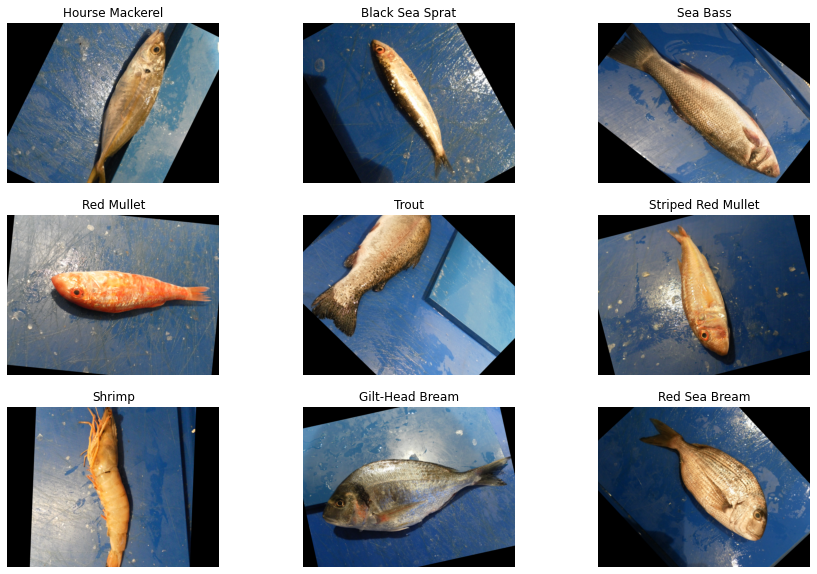

In [6]:
import random
fig, axs = plt.subplots(3,3,figsize=(15,10))
for i,x in enumerate(df.Name.value_counts().index):
    img = plt.imread(random.choice(df.loc[df.Name==df.Name.value_counts().index[i]].Path.to_list()))
    axs[int((i-i%3)/3),i%3].imshow(img)
    axs[int((i-i%3)/3),i%3].axis('off')
    axs[int((i-i%3)/3),i%3].set_title(x)

In [7]:
# Building Image Pipeline Referenced:
# https://www.kaggle.com/namtrn021200/fish-classification-tensorflow-input-pipeline

dataset = tf.data.Dataset.from_tensor_slices((df.Path,df.Label))
def get_train_val_test_split(ds,shuffle=True,shuffle_size=5000):
    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size=int(ds_size*.8)
    val_size=int(ds_size*.1)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_train_val_test_split(dataset)

2022-02-27 10:09:38.167634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 10:09:38.288416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 10:09:38.289098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 10:09:38.291437: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
# for x in train_ds:
#     print(x)

In [9]:
def load_images(filename,label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize(image,(224,224))
    return image,label
def augment(image,label):
    image = tf.image.random_brightness(image,max_delta=.2)
    image = tf.image.random_flip_left_right(image)
    iamge = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image)
    image = tf.image.stateless_random_jpeg_quality(image,min_jpeg_quality=90,
                                                  max_jpeg_quality=100,
                                                  seed=(np.random.randint(100),
                                                       np.random.randint(100)))
    return image,label

In [10]:
BATCH_SIZE=32
train_ds = (train_ds
    .shuffle(len(train_ds)*100,seed=42)
    .map(load_images)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE))
test_ds =(test_ds
         .shuffle(len(test_ds)*100)
         .map(load_images)
         .cache()
         .batch(BATCH_SIZE)
         .prefetch(tf.data.AUTOTUNE))
val_ds =(val_ds
         .shuffle(len(test_ds)*100)
         .map(load_images)
         .cache()
         .batch(BATCH_SIZE)
         .prefetch(tf.data.AUTOTUNE))
batch = next(iter(train_ds))

2022-02-27 10:09:40.942182: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-27 10:09:41.652245: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [11]:
import tensorflow_hub as hub

resnet_url = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5'
feature_extractor_layer = hub.KerasLayer(resnet_url,
                                        trainable=False,
                                        name='feature_extraction_layer',
                                        input_shape=(224,224,3))
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                              patience=3,
                                                              verbose=1,
                                                              factor=.5,
                                                              min_lr=.00001)
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(9,activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
history = model.fit(train_ds,
                 epochs=20,
                 validation_data=val_ds,
                 callbacks=[learning_rate_reduction])

Epoch 1/20


2022-02-27 10:09:52.033929: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


225/225 [==============================] - 113s 460ms/step - loss: 0.2375 - accuracy: 0.9519 - val_loss: 0.0741 - val_accuracy: 0.9878
Epoch 2/20
225/225 [==============================] - 7s 31ms/step - loss: 0.0262 - accuracy: 0.9993 - val_loss: 0.0431 - val_accuracy: 0.9922
Epoch 3/20
225/225 [==============================] - 7s 30ms/step - loss: 0.0131 - accuracy: 0.9999 - val_loss: 0.0314 - val_accuracy: 0.9933
Epoch 4/20
225/225 [==============================] - 7s 31ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 0.9956
Epoch 5/20
225/225 [==============================] - 7s 30ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0220 - val_accuracy: 0.9967
Epoch 6/20
225/225 [==============================] - 7s 31ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0195 - val_accuracy: 0.9967
Epoch 7/20
225/225 [==============================] - 7s 30ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 0.9967
Epoch 8

In [12]:
#  import seaborn as sns
# def plot_history(history):
#     fig,ax = plt.subplots(1,2,figsize=(16,6))
#     history_data = pd.DataFrame(history.history)
#     sns.lineplot(data=history_data[['loss','val_loss']],ax=ax[0])
#     sns.lineplot(data=history_data[['accuracy','val_accuracy']],ax=ax[1])
#     ax[0].set_xlabel('Epochs')
#     ax[1].set_xlabel('Epochs');
# plot_history(history)

In [13]:
from sklearn.metrics import classification_report
test_data = [label.numpy() for example, label in test_ds]
y_test = np.concatenate(np.array(test_data))
y_test_class = [classes[x] for x in y_test]
y_pred = tf.argmax(model.predict(test_ds),axis=1)
y_pred_class = [classes[x] for x in y_pred]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
# # singleImgPath = ../input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00001.png
# singleImage = plt.imread('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Gilt-Head Bream/Gilt-Head Bream/00001.png')

# sampleImg = (train_ds
#     .shuffle(len(train_ds)*100,seed=42)
#     .map(load_images)
#     .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
#     .cache()
#     .batch(BATCH_SIZE)
#     .prefetch(tf.data.AUTOTUNE))

# print(df.loc[df.Name==df.Name.value_counts().index[i]].Path.to_list())
# plt.imread(df.loc[df.Name==df.Name.value_counts().index[i]].Path.to_list())
# ax.imshow(singleImage)
# plt.title('matplotlib.pyplot.imread() function Example', fontweight ="bold")
# plt.show()

## from sklearn.metrics import classification_report
test_data = [label.numpy() for example, label in test_ds]
y_test = np.concatenate(np.array(test_data))
y_test_class = [classes[x] for x in y_test]
y_pred = tf.argmax(model.predict(test_ds),axis=1)
y_pred_class = [classes[x] for x in y_pred]
print(classification_report(y_test_class,y_pred_class))

In [15]:
path_img = '../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00007.png'
ds_img = [[path_img,-1,'Temp']]
df_img = pd.DataFrame(ds_img,columns=['Path','Label','Name'])
image_set = tf.data.Dataset.from_tensor_slices((df_img.Path,df_img.Label))

In [16]:
# for x in image_set:
#     print(x)

In [17]:
image_set =(image_set
         .shuffle(len(image_set)*100)
         .map(load_images)
         .cache()
         .batch(BATCH_SIZE)
         .prefetch(tf.data.AUTOTUNE))

In [18]:
#  tf.argmax(model.predict(test_ds),axis=1)
arr = model.predict(image_set)
arr=arr[0]
print(arr)

[4.0404711e-08 2.0330178e-08 9.9999928e-01 1.1965670e-10 1.6372523e-09
 2.9028079e-08 1.8222072e-09 4.3195694e-10 5.5349363e-07]


In [19]:
max_val=0
length=len(arr)

for x in range(length): 
     if(arr[x] > arr[max_val]):
        max_val=x
        
print(max_val)
    



2


In [20]:
KERAS_MODEL_NAME="fish_model_file.h5"

In [21]:
model.save(KERAS_MODEL_NAME)

In [22]:
TF_LITE_MODEL_FILE_NAME="tf_lite_model_new.tflite"
 

In [23]:
tf_lite_converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=tf_lite_converter.convert()

2022-02-27 10:14:59.204550: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-02-27 10:15:02.976650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 10:15:02.977022: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-02-27 10:15:02.978076: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-02-27 10:15:02.979423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 10:15:02.979927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had ne

In [24]:
tflite_model_name=TF_LITE_MODEL_FILE_NAME
open(tflite_model_name,"wb").write(tflite_model)

16975332